# Data for validation on ANN 

Date: 05.11.2025

In this notebook I simulate with differente seed, the ABM conditions, such that:
1. we can validate the ANN learning of the chi-values
2. Do a more holistic correlation analysis

In [1]:
#import functions from src file
import os
import sys

# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.ABRam_BG_V01 import *

In [2]:
#Import necessary packages 
import pandas as pd
import numpy as np
import agentpy as ap
import matplotlib.pyplot as plt

# for CI 
from statsmodels.stats.proportion import proportion_confint

In [3]:
#We set the parameter values for the farms
alpha, delta, rho = 0.33, 0.05, 0.99
#Parameter such that farms investment is bigger that its capital depreciation, i.e I > delta K
Omega = (delta + (1/(rho*alpha)))**(1/(1 - alpha))
#Parameter such that farms investment is positive
omega = ((1-delta)/(alpha*rho))**(1/(1-alpha))
#Periods 
periods = 50

In [4]:
# Configuration with 5% green in the system
perc = 0.30

#Number of farms in the system
Farms = 100
green_farms = int(perc*Farms)
brown_farms = Farms - green_farms

#Total Initial capital in the systes
Tot_K0 = 10
Tot_G0 = perc*Tot_K0
Tot_B0 = Tot_K0 - Tot_G0

#Farms initial capital (Initially, they just own one type of capital)
frm_B0 = Tot_B0/brown_farms
frm_G0 = Tot_G0/green_farms

#Initial technical progress
gamma0 = Omega*frm_G0 + 1
beta0 = gamma0/perc

In [5]:
#We declare the dictionary of parameters for the simulation 
parameters = {
    'agents':Farms,
    'steps': periods,
    'delta': delta,
    'alpha': alpha,
    'rho': rho,
    'green_perc': perc,
    'Tot_K0': Tot_K0,

    'interaction': True, #False
    'opinion_dynamics': True,
    'interaction_type': 'Voter', #MajorityRule
    'interacting_farms':3,#[0,3,0,3,3,0,1],
    'network_topology': 'FC',
    'number_of_friends': 5,
    'network_randomness': 0.5,
    'time_steps_in_1_year':4,
    'seed':22,
    'emissions':False,
    'draw_network':False #For visualization draw initial and final network
}

# # #We run the model 
# model = Economy(parameters)
# r_constant = model.run()

#Sample generation
# sample = ap.Sample(parameters, randomize=False)

# #We run 350 simulations for each social integration strategy
# exp = ap.Experiment(ABRam_BG.Economy, parameters, iterations=350, record=True) 
# voter_interactions = exp.run()

In [6]:
#Generating samples
exp_parameters = parameters.copy()

exp_parameters['green_perc'] = ap.Values(0.05,0.07,0.10,0.12,0.15,0.20,0.25,0.30,0.35,0.40)

sample = ap.Sample(exp_parameters)

In [7]:
#Run simulation with uniform sample size
sample_size = 400
#We run 400 simulations for each social integration strategy
exp = ap.Experiment(Economy, sample, iterations=sample_size, record=True) 
#Fix seed for reproducibility
exp.seed = 12345
#Run experiment
voter_interactions = exp.run()

Scheduled runs: 4000
Completed: 4000, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:07:17.897811


In [8]:
#Prepare data
FARMS =  voter_interactions.variables.Farm
#Computing green shares
STATS = voter_interactions.variables.Statistician
STATS['GOS'] = STATS.Total_P_G/STATS.GDP
STATS['GKS'] = STATS.Total_G/STATS.Total_K
STATS['G_farms'] = Farms - STATS.B_farms

In [9]:
#Proportion of green transitions per sample for all experiments and their CI lenght
# Access samples ids
samples_id = list(STATS.index.get_level_values(0).unique())
percentages = list(exp_parameters['green_perc'].values)

#set empty dict
samples_proportion = []
samples_CI_lenght = []
for i, sample_id in enumerate(samples_id):
    print(f"sample no. {sample_id} - green:brown proportion {percentages[i]}")

    sample = STATS.loc[sample_id]
    #Access data at threshold period
    end_traj = sample.loc[:,:,periods-1]
    # Look for trajectories that reached a green economy
    successful_trajs = end_traj[end_traj['GOS'] >= 0.85]
    # count successfull trajectories
    num_successful_trajs = len(successful_trajs.index.get_level_values(0).unique())
    # compute proportion of successfull trajectories w.r.t. sample size
    proportion = num_successful_trajs/sample_size
    samples_proportion.append(proportion)
    print(f"proportion = {proportion:.2f}")

    #We compute the confidence interval
    ci_pos = proportion + 1.96*np.sqrt((proportion*(1 - proportion))/sample_size)
    ci_neg = proportion - 1.96*np.sqrt((proportion*(1 - proportion))/sample_size)
    CI_voter = [ci_neg,ci_pos]
    print(f"CI = ({ci_pos:.3f}, {ci_neg:.3f})")
    lenght = ci_pos - ci_neg
    samples_CI_lenght.append(lenght)
    print(f"CI lenght ={lenght:.2f}")


sample no. 0 - green:brown proportion 0.05
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 1 - green:brown proportion 0.07
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 2 - green:brown proportion 0.1
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 3 - green:brown proportion 0.12
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 4 - green:brown proportion 0.15
proportion = 0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 5 - green:brown proportion 0.2
proportion = 0.01
CI = (0.012, -0.002)
CI lenght =0.01
sample no. 6 - green:brown proportion 0.25
proportion = 0.04
CI = (0.053, 0.017)
CI lenght =0.04
sample no. 7 - green:brown proportion 0.3
proportion = 0.13
CI = (0.166, 0.099)
CI lenght =0.07
sample no. 8 - green:brown proportion 0.35
proportion = 0.39
CI = (0.435, 0.340)
CI lenght =0.10
sample no. 9 - green:brown proportion 0.4
proportion = 0.64
CI = (0.687, 0.593)
CI lenght =0.09


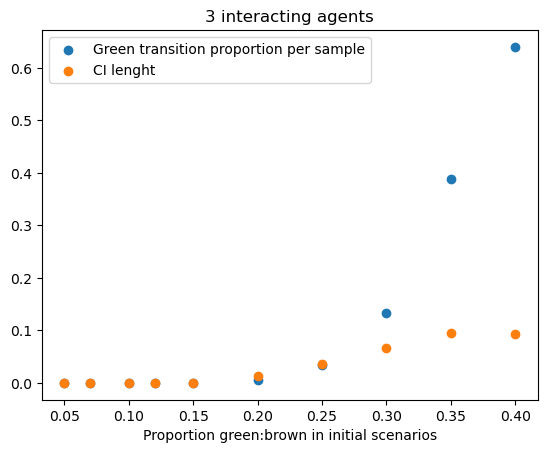

In [10]:
#Scatter plot
percentages
samples_proportion 
plt.scatter(percentages, samples_proportion, label= "Green transition proportion per sample")
plt.scatter(percentages, samples_CI_lenght, label="CI lenght")
plt.xlabel("Proportion green:brown in initial scenarios")
plt.title("3 interacting agents")
plt.legend()
plt.show()

In [11]:
#initialize list
samples_proportion = []
samples_CI_lenght_CP = []

#Loop through samples
for i, sample_id in enumerate(samples_id):
    sample = STATS.loc[sample_id]
    end_traj = sample.loc[:,:,periods-1]

    #Count successful trajectories
    successful_trajs = end_traj[end_traj['GOS'] >= 0.85]
    num_successful_trajs = len(successful_trajs.index.get_level_values(0).unique())


    #compute proportion
    proportion = num_successful_trajs/sample_size
    samples_proportion.append(proportion)

    #Compute Clopper-Pearson exact 95% CI
    ci_low, ci_upp = proportion_confint(count=num_successful_trajs,
                                        nobs=sample_size,
                                        alpha=0.05,
                                        method='beta')
    
    #Store CI length
    ci_length = ci_upp - ci_low
    samples_CI_lenght_CP.append(ci_length)

    print(f'{sample_id}) green-to-brown ratio = {percentages[i]}, proportion={proportion:.3f}, CI = ({ci_low:.3f}, {ci_upp:.3f}), lenght={ci_length:.3f}')

0) green-to-brown ratio = 0.05, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
1) green-to-brown ratio = 0.07, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
2) green-to-brown ratio = 0.1, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
3) green-to-brown ratio = 0.12, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
4) green-to-brown ratio = 0.15, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
5) green-to-brown ratio = 0.2, proportion=0.005, CI = (0.001, 0.018), lenght=0.017
6) green-to-brown ratio = 0.25, proportion=0.035, CI = (0.019, 0.058), lenght=0.039
7) green-to-brown ratio = 0.3, proportion=0.133, CI = (0.101, 0.170), lenght=0.069
8) green-to-brown ratio = 0.35, proportion=0.388, CI = (0.339, 0.437), lenght=0.098
9) green-to-brown ratio = 0.4, proportion=0.640, CI = (0.591, 0.687), lenght=0.096


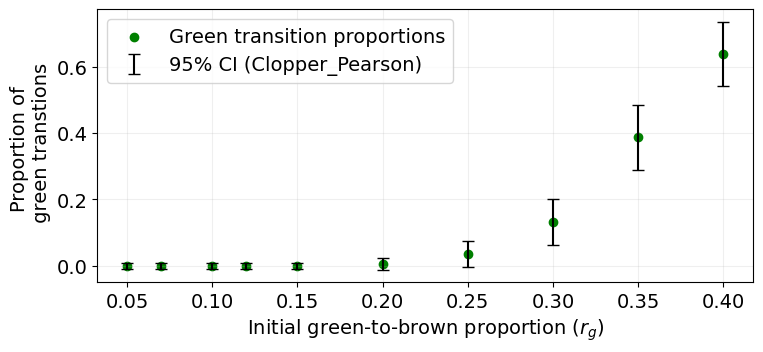

In [12]:
plt.rcParams['font.size'] = 14

#Compute half-lengths of CI for errorbar plotting
ci_half = np.array(samples_CI_lenght_CP)

fig, ax = plt.subplots(figsize= (215/25.4, 180/(2*25.4),))

#Scatter points for the proportions
plt.scatter(percentages, samples_proportion, color= 'green', label='Green transition proportions')

#add CI bars
plt.errorbar(
    percentages,
    samples_proportion,
    yerr=ci_half,
    fmt='none',
    ecolor='black',
    capsize=4,
    label='95% CI (Clopper_Pearson)'
)

#Labels and title
plt.xlabel('Initial green-to-brown proportion'+r' ($r_g$)')
plt.ylabel('Proportion of \n green transtions')
plt.grid(alpha=0.2)
plt.legend()



In [13]:
#Microvariables
#Select microvariables we are interested
production = FARMS[['P_B', 'P_G']]
#shape data as  production vectors
productions = production.stack(level=-1)
#starting points from t=[0:periods-1]
xs = productions.loc[:,:,:,:periods-1]
xs_farms = xs.unstack(level=0).unstack(level=0).unstack(level=1)
xs_farms = xs_farms.to_numpy()

#propagation points from t= [1:periods]
ys = productions.loc[:,:,:,1:]
ys_farms = ys.unstack(level=0).unstack(level=0).unstack(level=1)
ys_farms = ys_farms.to_numpy()

In [14]:
STATS.head()

Total_G        Total_B        Total_K  \
sample_id iteration obj_id t                                           
0         0         101    0  0.500000       9.500000      10.000000   
                           1  0.887434     111.164735     112.052169   
                           2  1.575078    1300.799822    1302.374900   
                           3  2.795555   15221.375536   15224.171090   
                           4  4.961740  178113.702965  178118.664705   

                                  real_beta  real_gamma           GDP  \
sample_id iteration obj_id t                                            
0         0         101    0      30.881364    1.544068  4.455340e+02   
                           1     361.359861    2.740517  5.182380e+03   
                           2    4228.470861    4.864055  6.058677e+04   
                           3   49479.667672    8.633054  7.088613e+05   
                           4  578988.857474   15.322529  8.294603e+06   

                              Total_P_G     Total_P_B  B_farms       GOS  \
sample_id iteration obj_id t                                               
0         0         101    0   3.128791  4.424052e+02       95  0.007023   
                           1   5.553190  5.176827e+03       95  0.001072   
                           2   9.856178  6.057691e+04       95  0.000163   
                           3  17.493412  7.088438e+05       95  0.000025   
                           4  31.048492  8.294572e+06       95  0.000004   

                                   GKS  G_farms  
sample_id iteration obj_id t                     
0         0         101    0  0.050000        5  
                           1  0.007920        5  
                           2  0.001209        5  
                           3  0.000184        5  
                           4  0.000028        5

In [15]:
#Macrovariables
macro_var = STATS
macro_var = macro_var.stack(level=-1)
#starting points from t=[0:periods-1]
xs_macro = macro_var.loc[:,:,:,:periods-1]
xs_macro = xs_macro.unstack(level=0).unstack(level=0).unstack(level=1)
xs_macro = xs_macro.to_numpy()

#Propagating points from t=[1:periods]
ys_macro = macro_var.loc[:,:,:,1:]
ys_macro = ys_macro.unstack(level=0).unstack(level=0).unstack(level=1)
ys_macro = ys_macro.to_numpy()

In [16]:
xs_macro

array([[5.00000000e-01, 8.87433863e-01, 1.57507772e+00, ...,
        3.87665872e+19, 9.84234635e+19, 2.49939347e+20],
       [9.50000000e+00, 1.11164735e+02, 1.30079982e+03, ...,
        8.17193503e+18, 1.55464314e+19, 2.95678835e+19],
       [1.00000000e+01, 1.12052169e+02, 1.30237490e+03, ...,
        4.69385223e+19, 1.13969895e+20, 2.79507231e+20],
       ...,
       [7.02256361e-03, 1.07155198e-03, 1.62678727e-04, ...,
        8.67815873e-01, 8.97549216e-01, 9.21224124e-01],
       [5.00000000e-02, 7.91982763e-03, 1.20938888e-03, ...,
        8.25901314e-01, 8.63591772e-01, 8.94214245e-01],
       [5.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
        7.30000000e+01, 7.30000000e+01, 7.30000000e+01]])

In [17]:
#construct data structures
#Construct starting points
xs = np.vstack((xs_farms, xs_macro))
#Construct propagating points
ys = np.vstack((ys_farms, ys_macro))

In [18]:
#Check if the shape of both are the same
xs.shape == ys.shape

True

In [19]:
#reshape ys to the required structure for ISOKANN
ndim, nsample = ys.shape[0], ys.shape[1]

ys = ys.reshape(ndim, 1, nsample) 

In [20]:
#save data to get them into Julia

# Create the path and ensure the directory exists for saving the data
data_dir = os.path.join( "..", 'data', 'simulations')
os.makedirs(data_dir, exist_ok=True)

# Build full path
file_path = os.path.join(data_dir, "20225-11-05-Simulation_data_for_validation.npz")

# Save xs and ys in the same file
np.savez(file_path, xs=xs, ys=ys)